# Machine Learning in Python - Group Project 2

Github link: https://github.com/monicasteph97/mlp-project-2-group-45

*Matthew Backhouse, Monica Stephanie, Ross Campbell, Royce Yan*

## General Setup

In [1]:
# Data libraries
import numpy as np
import pandas as pd

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn modules that are necessary. use sklearn==1.2.1
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PowerTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, f1_score, recall_score, precision_score, roc_curve, auc
from sklearn import set_config
from imblearn.over_sampling import RandomOverSampler

# Other modules that are necessary
from datetime import datetime, timedelta
from pandasql import sqldf
import requests
import warnings
import time

# Plotting defaults
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['figure.dpi'] = 80
sns.set_theme(style='darkgrid')
%matplotlib inline
pd.options.display.max_columns = 200
pd.options.display.max_rows = 20

# Others
warnings.filterwarnings('ignore')
# set_config(transform_output='pandas')

In [2]:
# Load data
data = pd.read_csv('hotel.csv')

## 1. Introduction

The aim of this project is to create a model that accurately predicts if a hotel booking will be cancelled or not. Hotel companies can use this model by inputting all of the necessary variables for a booking (i.e length of stay) and the model output a yes or no answer if the booking will be cancelled. To fully grasp our understanding of the model we will be exploring which aspects of the booking will effect the likelehood of cancellation. 

We will building the model around the variable *is_canceled* which is a binary output; cancelled or not cancelled represented as 1 and 0 respectively. The data collected is from https://sciencedirect.com/science/article/pii/S2352340918315191#f0010 These data sets come from the booking systems of two real hotels, one resort and one city, and reflect bookings made between July 1st, 2015 through August 31st 2017. The data set used is large with almost 120,000 observations.

The decisions around our model will be made will be in the best interest of the hotel and it's management. This means that we will be exploring the potential benefits and drawbacks of using this model from the point of view of the hotel. 

The breakdown of the report is as follows:

- [**Section 2: Exploratory data analysis and feature engineering:**](#2) The objective of this section is to explore the data. This includes finding correlations and relationships amongst features, and identifying key factors affecting *is_canceled*. We will also clean the data by removing duplicates, fixing spelling errors amongst other minor changes. On this validated data, we extract features to produce more statistical and impactful features based on data. Finally, we construct the pipeline to standardise, encode and reduce the dimension of data, as a groundwork for the following section.
- [**Section 3: Model Fitting and Tuning:**](#3) This section aims to choose the most appropriate model for our data, tune the hyperparameters involved, finalise the model with the set of optimal hyperparameters, fit the data into the model, and evaluating its performance on the training and test set.
- [**Section 4: Discussion and conclusion**](#4): This section gives a summarisation of the keys findings in section 2 & 3. We will adress the perfomance of our model in terms of potential gains and losses. A conclusion will be made whether or not our model is/isn't economically viable.
- [**Section 5: References**](#5): This section provides any references used throughout the report. This can include refernces both for code and for text.

## <a id=2> 2. Exploratory Data Analysis and Feature Engineering </a>

The following section reviews and analyzes the data to ensure it is preprocessed appropriately for the model in section 3. The dataset is cleaned in section 2.2 based on our observations in section 2.1. Feature extraction is conducted to adjust certain features, and the correlations among the numerical data is determined, and analysis on categorial data is also conducted. Analyzing correlations and the categorical data, more features are adjusted to make the dataset more readable and condensed while still providing an accurate depiction of the dataset. Based on all previous analysis, certain features are removed, either due to high correlation or high cardinality. Finally, the numeric columns are standardized and the categorical columns are encoded. This section will ensure that the data is appropriately analyzed, cleaned and preprocessed so that it is ready for our model.

The section is broken down into the following subsections:

- [**2.1. Data Exploration**](#21): Provide an overview of data set 'data'. The data is described by giving statistics, duplicate values for each column, irrelevant values and data structure so that readers can better understand the data and to identify any necessary data cleaning.
- [**2.2. Data Cleaning**](#22): Clean the data based on data exploration.
- [**2.3. Feature Extraction**](#23): Transform pariular features of the dataset based on data exploration and cardinality.
- [**2.4. Data Correlation**](#24): Understand the correlation among numeric and categorical features.
- [**2.5. Feature Selection and Scaling**](#25): Remove features based on previous analysis, standardize numeric values and encode categorical values which is conducted with the created pipeline. 

### <a id=21>  2.1. Data Exploration </a>

This subsection aims to provide a comprehensive view of the datasets. The data structure, duplicate values identifier, unique values, descriptive analysis, and irrelevant values are also provided. This is all to help identify any data cleaning that might be necessary.

In [3]:
print('----- Data Structure -----')
display(data.info())
    
print('----- Unique Values -----')
# Convert agent and repeated_guest to string
data.loc[:, ['agent', 'is_repeated_guest']] = data.loc[:, ['agent', 'is_repeated_guest']].astype(str)
data_cat = data.select_dtypes(include=['object'])
for col in data_cat.columns:
    unique_vals = sorted(data_cat[col].dropna().unique())
    length_unique_vals = len(unique_vals)
    print(f'{col} has {length_unique_vals} unique values.')
    
print('\n----- Descriptive Analysis -----')
display(data.describe())

print('---- Irrelevant Values -----')
print('1. Hotel just confirmed the booking on the arrival date although the booking has been made prior')
display(data[(data['days_in_waiting_list'] == data['lead_time']) & (data['days_in_waiting_list'] != 0)])
print('2. Lead time is more than a year')
display(data[data['lead_time'] > 365])
print('3. Adr is negative')
display(data[data['adr'] < 0])
print('4. Total adults, kids, and babies is 0')
display(data[data[['adults', 'children', 'babies']].sum(axis=1)==0])

----- Data Structure -----
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 30 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   is_canceled                     119390 non-null  int64  
 1   hotel                           119390 non-null  object 
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  in

None

----- Unique Values -----
hotel has 2 unique values.
arrival_date_month has 12 unique values.
meal has 5 unique values.
country has 177 unique values.
market_segment has 8 unique values.
distribution_channel has 5 unique values.
is_repeated_guest has 2 unique values.
reserved_room_type has 10 unique values.
assigned_room_type has 12 unique values.
deposit_type has 3 unique values.
agent has 334 unique values.
customer_type has 4 unique values.

----- Descriptive Analysis -----


,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,previous_cancellations,previous_bookings_not_canceled,booking_changes,company,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
count,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119386.000000,119390.000000,119390.000000,119390.000000,119390.000000,6797.000000,119390.000000,119390.000000,119390.000000,119390.000000
mean,0.370416,104.011416,2016.156554,27.165173,15.798241,0.927599,2.500302,1.856403,0.103890,0.007949,0.087118,0.137097,0.221124,189.266735,2.321149,101.831122,0.062518,0.571363
std,0.482918,106.863097,0.707476,13.605138,8.780829,0.998613,1.908286,0.579261,0.398561,0.097436,0.844336,1.497437,0.652306,131.655015,17.594721,50.535790,0.245291,0.792798
min,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,0.000000,-6.380000,0.000000,0.000000
25%,0.000000,18.000000,2016.000000,16.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,62.000000,0.000000,69.290000,0.000000,0.000000
50%,0.000000,69.000000,2016.000000,28.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,179.000000,0.000000,94.575000,0.000000,0.000000
75%,1.000000,160.000000,2017.000000,38.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,270.000000,0.000000,126.000000,0.000000,1.000000
max,1.000000,737.000000,2017.000000,53.000000,31.000000,19.000000,50.000000,55.000000,10.000000,10.000000,26.000000,72.000000,21.000000,543.000000,391.000000,5400.000000,8.000000,5.000000


---- Irrelevant Values -----
1. Hotel just confirmed the booking on the arrival date although the booking has been made prior


,is_canceled,hotel,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests
2486,0,Resort Hotel,47,2015,October,43,19,1,4,2,0.0,0,HB,ESP,Groups,Direct,0,0,0,A,A,0,No Deposit,nan,NaN,47,Transient-Party,76.8,0,0
2487,0,Resort Hotel,47,2015,October,43,19,1,4,2,0.0,0,HB,ESP,Groups,Direct,0,0,0,A,A,0,No Deposit,nan,NaN,47,Transient-Party,76.8,0,0
2488,0,Resort Hotel,47,2015,October,43,19,1,4,2,0.0,0,HB,ESP,Groups,Direct,0,0,0,A,A,0,No Deposit,nan,NaN,47,Transient-Party,76.8,0,0
2490,0,Resort Hotel,47,2015,October,43,19,1,4,2,0.0,0,HB,ESP,Groups,Direct,0,0,0,A,A,0,No Deposit,nan,NaN,47,Transient-Party,76.8,0,0
2491,0,Resort Hotel,47,2015,October,43,19,1,4,2,0.0,0,HB,ESP,Groups,Direct,0,0,0,A,A,0,No Deposit,nan,NaN,47,Transient-Party,76.8,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79623,0,City Hotel,6,2015,October,44,28,0,3,2,0.0,0,BB,ISR,Groups,TA/TO,0,0,0,A,A,1,No Deposit,37.0,NaN,6,Transient-Party,75.0,0,0
79624,0,City Hotel,6,2015,October,44,28,0,3,2,0.0,0,HB,ISR,Groups,TA/TO,0,0,0,A,A,0,No Deposit,37.0,NaN,6,Transient-Party,107.0,0,0
79625,0,City Hotel,6,2015,October,44,28,0,3,2,0.0,0,HB,ISR,Groups,TA/TO,0,0,0,A,A,0,No Deposit,37.0,NaN,6,Transient-Party,107.0,0,0
79649,0,City Hotel,6,2015,October,44,28,0,3,1,0.0,0,HB,ISR,Groups,TA/TO,0,0,0,A,A,1,No Deposit,37.0,NaN,6,Transient-Party,86.0,0,0


2. Lead time is more than a year


,is_canceled,hotel,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests
1,0,Resort Hotel,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,nan,NaN,0,Transient,0.00,0,0
81,1,Resort Hotel,368,2015,July,27,3,3,7,2,0.0,0,BB,PRT,Offline TA/TO,TA/TO,0,0,0,A,A,0,No Deposit,40.0,NaN,0,Contract,55.68,0,0
225,0,Resort Hotel,394,2015,July,28,8,2,5,2,0.0,0,HB,GBR,Offline TA/TO,TA/TO,0,0,0,D,D,0,No Deposit,40.0,NaN,0,Contract,89.68,0,0
245,0,Resort Hotel,366,2015,July,28,9,2,5,2,0.0,0,HB,GBR,Offline TA/TO,TA/TO,0,0,0,E,E,0,No Deposit,40.0,NaN,0,Contract,134.73,0,0
890,0,Resort Hotel,460,2015,August,32,3,2,5,1,0.0,0,HB,GBR,Offline TA/TO,TA/TO,0,0,0,E,E,0,No Deposit,40.0,NaN,0,Contract,77.54,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119102,0,City Hotel,518,2017,August,34,26,2,1,1,0.0,0,BB,PRT,Groups,TA/TO,0,0,0,A,A,1,No Deposit,229.0,NaN,0,Transient-Party,0.00,0,0
119107,0,City Hotel,518,2017,August,34,26,2,1,2,0.0,0,BB,AUS,Groups,TA/TO,0,0,0,A,A,0,No Deposit,229.0,NaN,0,Transient-Party,112.67,0,1
119109,0,City Hotel,518,2017,August,34,26,2,1,2,0.0,0,BB,GBR,Groups,TA/TO,0,0,0,A,A,0,No Deposit,229.0,NaN,0,Transient-Party,112.67,0,1
119111,0,City Hotel,518,2017,August,34,26,2,1,2,0.0,0,BB,GBR,Groups,TA/TO,0,0,0,A,A,0,No Deposit,229.0,NaN,0,Transient-Party,112.67,0,1


3. Adr is negative


,is_canceled,hotel,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests
14969,0,Resort Hotel,195,2017,March,10,5,4,6,2,0.0,0,BB,GBR,Groups,Direct,1,0,2,A,H,2,No Deposit,273.0,NaN,0,Transient-Party,-6.38,0,0


4. Total adults, kids, and babies is 0


,is_canceled,hotel,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests
2224,0,Resort Hotel,1,2015,October,41,6,0,3,0,0.0,0,SC,PRT,Corporate,Corporate,0,0,0,A,I,1,No Deposit,nan,174.0,0,Transient-Party,0.00,0,0
2409,0,Resort Hotel,0,2015,October,42,12,0,0,0,0.0,0,SC,PRT,Corporate,Corporate,0,0,0,A,I,0,No Deposit,nan,174.0,0,Transient,0.00,0,0
3181,0,Resort Hotel,36,2015,November,47,20,1,2,0,0.0,0,SC,ESP,Groups,TA/TO,0,0,0,A,C,0,No Deposit,38.0,NaN,0,Transient-Party,0.00,0,0
3684,0,Resort Hotel,165,2015,December,53,30,1,4,0,0.0,0,SC,PRT,Groups,TA/TO,0,0,0,A,A,1,No Deposit,308.0,NaN,122,Transient-Party,0.00,0,0
3708,0,Resort Hotel,165,2015,December,53,30,2,4,0,0.0,0,SC,PRT,Groups,TA/TO,0,0,0,A,C,1,No Deposit,308.0,NaN,122,Transient-Party,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115029,0,City Hotel,107,2017,June,26,27,0,3,0,0.0,0,BB,CHE,Online TA,TA/TO,0,0,0,A,A,1,No Deposit,7.0,NaN,0,Transient,100.80,0,0
115091,0,City Hotel,1,2017,June,26,30,0,1,0,0.0,0,SC,PRT,Complementary,Direct,0,0,0,E,K,0,No Deposit,nan,NaN,0,Transient,0.00,1,1
116251,0,City Hotel,44,2017,July,28,15,1,1,0,0.0,0,SC,SWE,Online TA,TA/TO,0,0,0,A,K,2,No Deposit,425.0,NaN,0,Transient,73.80,0,0
116534,0,City Hotel,2,2017,July,28,15,2,5,0,0.0,0,SC,RUS,Online TA,TA/TO,0,0,0,A,K,1,No Deposit,9.0,NaN,0,Transient-Party,22.86,0,1


From the above information, it can be concluded that:

> - *agent* and *is_repeated_guest* are not strings.
> - Most of *company* data is null.
> - *children, country, agent* contain null values.
> - *country* and *agent* has high cardinality (177 and 334 unique values respectively).
> - There are 62 rows where days in waiting list equals to lead time and the value is not zero, which indicates that the hotel confirmed the booking on the d-day even though the booking has been made prior.
> - There are 3148 rows where lead time is more than a year. Generally, you can only book a hotel 1 year in advance.
> - There is 1 row where the adr is negative which implies that the lodging transactions are negative.
> - There are 180 rows where the total adults, children, and babies equals to 0.

### <a id=22>  2.2. Data Cleaning </a>

Based on the data descriptions above, we have identifed issues with our data that need to be fixed, or areas of our data that should be cleaned. In this section the following tasks are performed on the data:

> - Remove *company* column due to high percentage of null values
> - Impute null values in *children* with 0, while in *country, agent* with 'null'
> - Remove rows with irrelevant values that are stated in previous subsection

In [4]:
# Remove company column
df = data.drop(columns='company')

# Impute null values in children, country, and agent
df.loc[:, ['country', 'agent']] = df.loc[:, ['country', 'agent']].fillna('null')
df.loc[:, 'children'] = df.loc[:, 'children'].fillna(0)

# Remove unreasonable data
df = df[((df['days_in_waiting_list'] < df['lead_time']) | (df['lead_time'] == 0))
        & (df['lead_time'] < 365)
        & (df['adr'] >= 0)
        & (df[['adults', 'children', 'babies']].sum(axis=1) > 0)
       ].copy().reset_index(drop=True)

# Convert arrival_date_month to numeric
df['arrival_date_month'] = df['arrival_date_month'].apply(lambda x: datetime.strptime(x, '%B').month)

# Convert is_repeated_guest to string
df['is_repeated_guest'] = df['is_repeated_guest'].astype(str)

### <a id=23> 2.3. Feature Extraction </a>

This section involves analyzing and identify the pertinent features for our target variable *is_canceled*. Features will be transformed and added here as well as other features that will be extracted.

As a preliminary exploration of the data at hand, we have identified the following:

- Canceled booking ratio by *country* and *agent* to replace *country* and *agent* columns respectively due to high cardinality. High cardinality will greatly affect the training time and intuitively, what we want to extract from the *country* and *agent* information is the portion of the canceled bookings for that particular data.
- Identifier whether *reserved_room_type* is the same as *assigned_room_type*

In order to avoid data leakage, we will canceled booking ratio by filtering the date. However, it is worth noting that there is no such column as *booking_date*, which indicates the time when the booking is recorded in the system; hence, we assume that *booking_date* is equivalent to *arrival_date* - *lead_time*. Due to the absence of *cancelation_date*, which indicates the time when the cancelation is made, we also assume that we already know the cancelation status of the orders that are booked prior to the date when the new booking is made. Our suggestion for further improvement is to retrieve the *cancelation_date* data from the system to prevent any possible data leakage.

In [5]:
# Extract booking_date to avoid data leakage
df.loc[:, 'arrival_date'] = df.apply(lambda x: datetime(x['arrival_date_year'], x['arrival_date_month'],
                                                 x['arrival_date_day_of_month']), axis=1)
df.loc[:, 'booking_date'] = df.apply(lambda x: x['arrival_date'] - timedelta(days=x['lead_time']), axis=1)
df.loc[:, 'arrival_date'] = df['arrival_date'].apply(lambda x: x.strftime('%Y-%m-%d'))
df.loc[:, 'booking_date'] = df['booking_date'].apply(lambda x: x.strftime('%Y-%m-%d'))


# Canceled booking ratio by country and agent
pysqldf = lambda q: sqldf(q, globals())
query_country = '''
                with country_rolling_sum as (select country, booking_date,
                max(canceled_booking_rolling) as canceled_booking_rolling,
                max(total_booking_rolling) as total_booking_rolling
                from
                (
                select country, booking_date,
                sum(is_canceled) over (partition by country order by booking_date) as canceled_booking_rolling,
                count(is_canceled) over (partition by country order by booking_date) as total_booking_rolling
                from df
                order by country, booking_date
                ) table1
                group by 1, 2),
                country_d_day as (
                select country, booking_date, sum(is_canceled) as canceled_booking,
                count(is_canceled) as total_booking
                from df
                group by 1, 2
                ),
                country_final as (
                select A.booking_date, A.country, A.canceled_booking_rolling - B.canceled_booking as canceled_booking_country,
                A.total_booking_rolling - B.total_booking as total_booking_country
                from country_rolling_sum A
                left join country_d_day B
                on A.booking_date = B.booking_date
                and A.country = B.country)
                select *
                from country_final
                '''
df_country = pysqldf(query_country)
query_agent = '''
                with agent_rolling_sum as (select agent, booking_date,
                max(canceled_booking_rolling) as canceled_booking_rolling,
                max(total_booking_rolling) as total_booking_rolling
                from
                (
                select agent, booking_date,
                sum(is_canceled) over (partition by agent order by booking_date) as canceled_booking_rolling,
                count(is_canceled) over (partition by agent order by booking_date) as total_booking_rolling
                from df
                order by agent, booking_date
                ) table1
                group by 1, 2),
                agent_d_day as (
                select agent, booking_date, sum(is_canceled) as canceled_booking,
                count(is_canceled) as total_booking
                from df
                group by 1, 2
                ),
                agent_final as (
                select A.booking_date, A.agent, A.canceled_booking_rolling - B.canceled_booking as canceled_booking_agent,
                A.total_booking_rolling - B.total_booking as total_booking_agent
                from agent_rolling_sum A
                left join agent_d_day B
                on A.booking_date = B.booking_date
                and A.agent = B.agent)
                select *
                from agent_final
                '''
df_agent = pysqldf(query_agent)

# Merge with original dataframe
df = df.merge(df_country, how='left', on=['booking_date', 'country'])
df = df.merge(df_agent, how='left', on=['booking_date', 'agent'])

df['ratio_canceled_country'] = df['canceled_booking_country'] / df['total_booking_country']
df['ratio_canceled_country'] = df['ratio_canceled_country'].fillna(0)
df['ratio_canceled_agent'] = df['canceled_booking_agent'] / df['total_booking_agent']
df['ratio_canceled_agent'] = df['ratio_canceled_agent'].fillna(0)

# Identifier whether reserved_room_type = assigned_room_type
df['res_assign'] = df.apply(lambda x: '1' if x['reserved_room_type'] == x['assigned_room_type'] else '0', axis=1)

### <a id=24> 2.4. Correlation </a>

The correlation method that is used is Spearman to identify the monotonic relationship between variables. This acts as a precursor to the feature selection that will occur in the next section, which will remove some highly correlated features or features that have little affect on the variance of our dataset will be removed.

#### 2.4.1 Numerical Features

<Axes: >

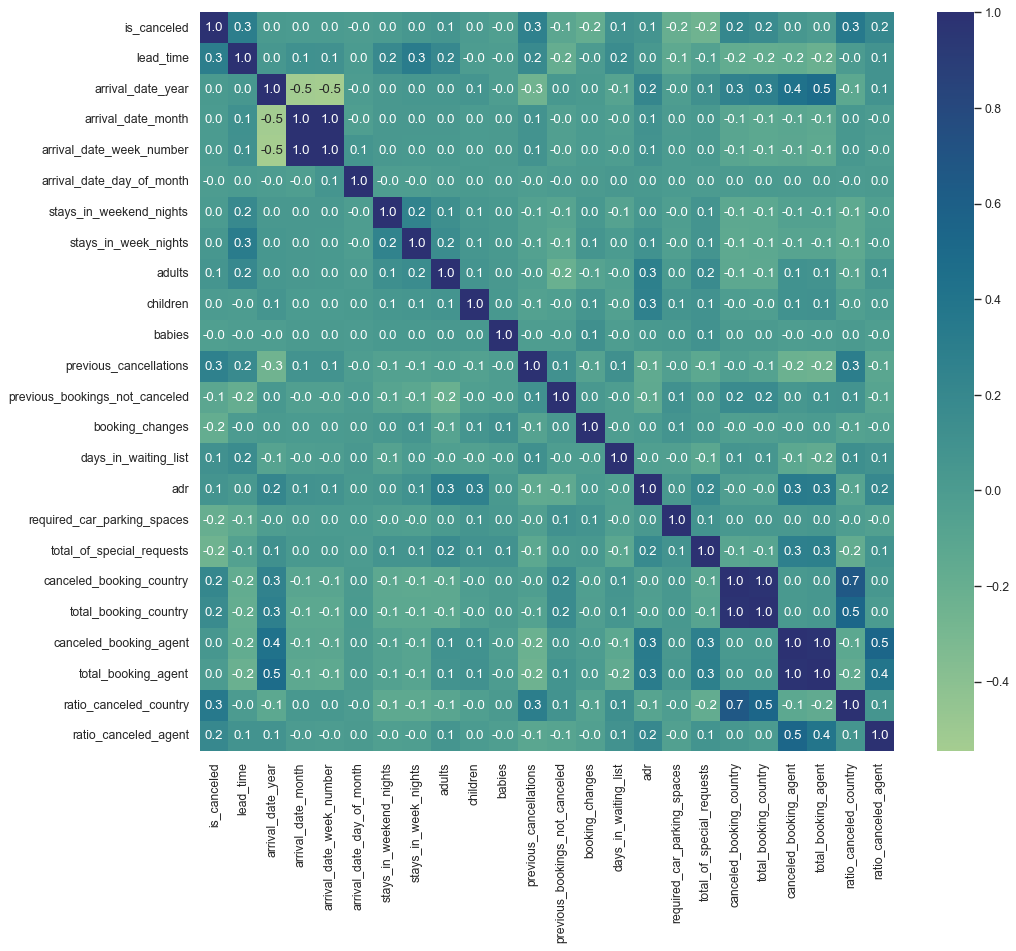

In [6]:
# Spearman correlation matrix
plt.figure(figsize=(14, 12))
sns.heatmap(df.corr(method='spearman'), annot=True, fmt='.1f', cmap='crest')

Based on the above graphs, there are several key takeaways as follows:

> - *arrival_date_year*, *arrival_date_month* and *arrival_date_week_number* are negatively correlated.
> - Many of the variables have low or negative correlation with non correlation above 0.5 of below -0.5, except for the correlation between *ratio_canceled_country* and *canceled_booking_country*. 
> - *ratio_canceled_agent* is not well correlated with many of the features aside from *canceled_booking_agent*.
> - *is_canceled* has some correlation with *previous_cancelations*, *ratio_canceled_country* and *lead_time*.

There are many other feature correlations going on here. The above are some key observations made with the large number of features.

<img src="spearman_interpretation.png" width=600>

The image above provides a view of the Spearman correlation coefficient and what the correlation coefficients values mean (values which can be seen in the heatmap). Spearman correlation coefficient is a non-parametric correlation coefficient that measures montonic relationships rather than  linear relationships. Pearson's correlation also considers that the data is approximiately normally distributed which we are unsure about. It is also easier to consider a montonic relationship in our data rather than a linear relationship as some of our data might not represent any type of linear relationship. Spearmans correlation coefficient is therefore the better correlation coefficient to use to measure the correlation among our features. 

By scrutinizing the correlations above, we note weak correlations between the *is_canceled* and some of our features, and strong correlations among some features themselves. Since a weak correlation to the target implies that the variable of concern might be irrelevant, and a significant correlation within features suggests some redundant dimensions in the matrix, the visualization of correlations serves as a clue for future data selection.

#### 2.4.2 Categorical Features

*distribution_channel* has similar values to *market_segment*, while *reserved_room_type* has similar values to *assigned_room_type*. Therefore, we are going to only use *market_segment* and *assigned_room_type* because they contain more detailed values and the distribution is more even. In addition, we will also remove *meal* because this column is highly dominated by one single value and intuitively, it is not quite relevant.

Market Segment: ['Direct' 'Corporate' 'Online TA' 'Offline TA/TO' 'Complementary' 'Groups'
 'Undefined' 'Aviation']
Distribution Channel: ['Direct' 'Corporate' 'TA/TO' 'Undefined' 'GDS']
Assigned Room Type: ['C' 'A' 'D' 'E' 'G' 'F' 'I' 'B' 'H' 'L' 'K']
Reserved Room Type: ['C' 'A' 'D' 'E' 'G' 'F' 'H' 'L' 'B']


Text(0, 0.5, 'Total Rows (%)')

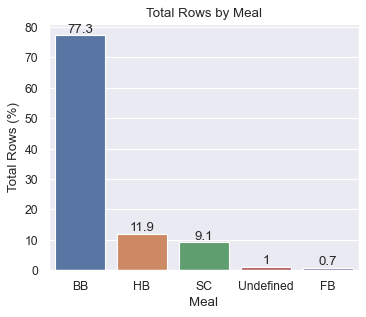

In [7]:
print(f'Market Segment: {df["market_segment"].unique()}')
print(f'Distribution Channel: {df["distribution_channel"].unique()}')
print(f'Assigned Room Type: {df["assigned_room_type"].unique()}')
print(f'Reserved Room Type: {df["reserved_room_type"].unique()}')

# Total rows by meal
plt.figure(figsize=(5,4))
ax = sns.barplot(pd.DataFrame(np.round(df['meal'].value_counts()/len(df)*100, 1)).reset_index(),
                         x='index', y='meal')
plt.bar_label(ax.containers[0])
plt.title('Total Rows by Meal')
plt.xlabel('Meal')
plt.ylabel('Total Rows (%)')

### <a id=25> 2.5. Feature Selection and Scaling </a>

#### 2.5.1 Feature Selection

Based on the previous section, we will remove numerical features that are highly correlated with each other and features that only have weak correlation to our label *is_canceled*. In addition, we will also remove any categorical feature that has high cardinality, contains similar value as other categorical column, or is highly dominated by one value.

In [8]:
removed_cols = ['arrival_date_year', 'arrival_date_week_number', 'arrival_date',
                'canceled_booking_country', 'canceled_booking_agent', 'meal',
                'country', 'distribution_channel', 'agent', 'reserved_room_type',
                'arrival_date', 'booking_date']

#### 2.5.2 Feature Scaling

The following function `preprocess` is the finalization of our data processing. Essentially the function has two main goals, to standardize the numerical values and to one hot encode the categorical values. However, this function also creates the pipeline for our model. The following is how each part of the pipeline is created:

1. **num_pipe**: This is where numerical values are scaled and standardized.
    * `SimpleImputer`: This is used to complete any missing values in the dataset. Particularly, the mean value of the numerical data is used to fill in missing values. Since the dataset is not large, a median or most frequent value would not be as appropriate as a the mean, since a median or most frequent number of the dataset may not represent the data well when filling in missing values. Adding a constant would also provide poor estimation and is not as flexible for any datasets and would require estimating the value based on assumptions of the data.
    * `StandardScaler`: This scales all the numerical data by subtracting the mean and dividing by the standard deviation of the column. This allows all the numerical data to be normalized and therefore future computations and model fitting will be more consistent.
    * `PowerTransformer`: This ensures that the data is closer to a Gaussian-like distribution. Each feature will be closer to a standard normal distribution. In particular, the yeo-johnson method is used as it accommodates for positive and negative values in our columns. Box-cox is another option, however, this only includes positive values. Therefore, yeo-johnson is the more flexible method and is preferred.   
2. **cat_pipe**: This is the part of the pipleine that endoces the categorical data.
    * `OneHotEncoder`: This class is used to one hot encode our data. The parameter *handle_unknown* is set to 'ignore'. This means that the when the encoder encounters an unknown category, the resulting one-hot encoded columns for this feature will be all zeros.
3. **pipeline**: This sets up the pipeline for the entire model. There are many parts of this pipeline, they are all explained below:
    * scaling: Here, the `ColumnTransformer` is used which specifies that when we use the keyword "num_cols" in our pipeline, we are only referring to the part of the pipeline **num_pipe** which contains our numerical data. The other features, which are categorical, will be skipped but still included in the rest of the pipeline. 
    * encode: Here, the `ColumnTransformer` is used which specifies that when we use the keyword "cat_cols" in our pipeline, we are only referring to the part of the pipeline **cat_pipe** which contains our categorical data. The other features, which are numerical will be skipped but still included in the rest of the pipeline.
    * model: This is where our final classification model will be placed in the pipeline.

In [9]:
def preprocess(model, num_cols, cat_cols, cols_preserved):
    """
    Parameters
    ----------
    model: machine learning model (sklearn model).
    num_cols: numerical columns that are going to be scaled (list).
    cat_cols: categorical columns that are going to be encoded (list).
    
    Returns
    -------
    pipeline: sklearn pipeline.
    """
    
    num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('num_scale', StandardScaler()),
    ('num_transform', PowerTransformer(method='yeo-johnson'))
    ])
    
    cat_pipe = Pipeline([
    ('cat_encode', OneHotEncoder(handle_unknown='ignore'))
    ])
    
    pipeline = Pipeline([
    ('transform', ColumnTransformer([
        ('num_cols', num_pipe, num_cols),
        ('cat_cols', cat_pipe, cat_cols)])),
    ('model', model)
    ])

    return pipeline

## <a id=3> 3. Model Fitting and Tuning </a>

This section defines the classification model that will be used to fit and make the prediction about customer cancellation. There are multiple functions employed to help fit the model and to help demonstrate the features that will contribute to a cancellation. The model used is the Random Forest Classifier, as this provides the best RMSE and an overall better $R^2$ score. This classification model was also determined by testing other models and investigating which models would produce the best results and which models would have less underfitting or overfitting. Overall the Random Forest Classifier turned out to be the best model. The features used, validation, and hyperparameter tuning are all presented in this section of the report. 

- [**3.1. Testing Models**](#31): Describes which other models were tested and why they were not used.
- [**3.2. Model Explanation**](#32): A high level overview of what the Random Forest Classifier is.
- [**3.3. Model Preparation**](#33): Functions are created to ensure that the model can be fitted and hyperparameters can be tuned.
- [**3.4. Model Fitting**](#34): Fitting the model to our data.
- [**3.5. Our Model Explained**](#35): An explanation of our specific model and it's predictive capability and performance factors.

### <a id=31> 3.1 Testing Models </a>

The following explains which models were tested, the results from each model, and why they were not used:

1. **Logistic Regression**: Logistic regression was the first model to be tested. The model performance is good with Recall score for training and testing data set are 0.809 and 0.812, while the ROC-AUC score for training and testing data set are 0.904 and 0.905. Although the model does not show any sign of overfitting, it does not really give an incredible result as well. We have tried to plot the relationship between features and it does not depict that there is a linear relationship between the features and the log-odds of the outcome. This might be the reason why the performance is mediocre.
2. **Linear Support Vector Classification**: After the trial for linear regression, we attempted to try Linear SVC, which is the same as SVC with parameter kernel='linear', except that it is more flexible in terms of penalties and loss functions, and scale better to large number of samples compared to SVC. The model produces Recall score of 0.771 for training and 0.772 for testing data set. Meanwhile, the ROC-AUC score is 0.748 for training and 0.754 for testing data set. These performance imply that the model is underfitting and the main reason is because the features do not have linear relationship.
3. **Decision Tree Classifier**: Next, we tried the decision tree classifier. This method may work better because the data set does not have to be linear. The model provides a Recall score of 0.996 and 0.815 for training and testing data set respectively. The ROC-AUC score for training and testing data set are 1 and 0.8 consecutively. Although the result is considerably good, it must be taken into account that the model seems to be overfitting, given the huge difference in training and testing data set.

Therefore, Random Forest Classifier is chosen because it is a model that does not need the assumption of linearity unline Logistic Regression or Linear Support Vector Classification, but will not overfit the training data as much as Decision Tree Classifier because it works by training many decision trees on random subset of features.

### <a id=32> 3.2 Model Explanation </a>

The following section will explain how Random Forest Classifier works. The specifics of our model are then explained in section 3.5.

The Random Forest Classifier is essentially multiple Decision Tree models. To understand Random Forest Classifier, it is necessary to first understand Decision Trees, specifically, Decision Tree Classifier models, as we are undergoing a classiifcation model. In particular, a Decision Tree is simply nested if and else statements. Consider a dataset that has $N$ features with features $\{x_0, x_1,...,x_N\}$, $D$ data points, and one target variable with $D$ data points $\{y^0, y^1,..., y^D\}$. The dataset will be split into two categories at each node, starting at the root node. Each node will have a condition, meaning how the dataset will be split depending on the parent nodes condition (e.g. $x_2 \leq 1$). If you look at all $D$ data points and compare them with this condition, then all data points that meet this condition are in the left node of the split, and all the data points that do not meet the condition are in the right node (e.g. data points with a data point where $x_2 \leq 1$ will be in the right node, and the data points that do not meet this condition will be in the left node). But how do we determine what this condition is? This requires calculating information gain. Essentially, the program will run through every feature, and every value that each feature can take, and determine the maximum information gain for every possible split that the data set could create. This is done for every node, until the final depth of the tree. Since trees are also used for the Random Forest Classifier, the tree depth will be determined by the **RandomizedSearchCV class from sklearn using the parameter *max_depth***.  

To calculate the infomration gain, we first need to calculate the entropy of each state/node of the tree. Entropy represents our uncertainty about the state/node of the tree. The higher the entropy the more uncertain we are about the predicting capabilities of our state/node. As an example, assume data is classified as red or blue and there are 10 blue data points and 10 red data points. At the root node, the entropy will be 1, which is the highest value entropy can take. This means that if we want a blue data point, and pick one randomly from the root node, the chance we get a blue data point is 50%. This is the worst predictive capability of a state/node. Enropy is calculated as follows:

$$Entropy = \sum -p_i log(p_i)$$

where $p_i$ is the probability of class $i$. Continuing the example above, the probability of a red data point is $\frac{10}{20} = 0.5$ and likewise for a blue data point. Then we can see that the above formula produces 1 as the result. The information gain is calculated as follows using entropy,

$$Information Gain = Entropy(parent) - \sum{w_i}Entropy(child)$$

where $Entropy(parent)$ is the entropy of the parent node, $Entropy(child)$ is the entropy of the child nodes, and $w_i$ are the weights which are simply the ratio of the number of data points in the child node, divided by the number of data points in the parent node (e.g. for $n$ datapoints, suppose that the split $x_i \leq 1$ results in $\frac{n}{3}$ on the left node which meets the condition and $\frac{2n}{3}$ on the right node. Then the weights would be $\frac{n/2}{n}$ and $\frac{2n/3}{n}$ respectively).

Eventually, the splits will end and there will be nodes with no condition, but rather, these final nodes (leaf nodes) are the data points that are finally split. Our data could be split into more than a single data point per leaf node, as we can have multiple data points per leaf node. Recall that each data point, $\{x_0^0,x_0^1,...x_0^D\},...,\{x_N^0,x_N^1,...,x_N^D\}$, has an associated output value $\{y^0,y^1,...,y^D\}$. Therefore, we attempt to end up with pure leaf nodes at the end of our tree, although this is not always the case, but the information gain will be minimized at each node of the tree. Essentially, when a new data point is added to try and create a prediction, the data point will run through the tree checking each condition and moving to the right or left node, until it ends up at a leaf node, which will ideally be pure and the prediction will identify it as the correct class. If the node is not pure but information gain is still small, then the leaf node will contain data points in both classes (with more data points in one class than the other).

The issue with a regular decision tree is that it is highly sensitive to the training dataset. The model is accustomed quite well to the training dataset, so when new values enter, the optimal conditions are no longer optimal as the variance reduction values would be different for our test set than our training set. This leads to overfitting with our Decision Tree.

To reduce overfitting from the Decision Tree, a Random Forest Classifier is used. The main idea behind the Random Forest Classifier is to create multiple Decision Trees rather than just have the one. This is done by bootstrapping the dataset. Bootstrapping is where we randomly sample $D$ data points, with replacement, from the dataset and create $M$ new datasets. For example, suppose we just have $4$ data points, $\{d_1, d_2, d_3, d_4\}$. Suppose we choose a simple $M$ value, $M=2$. Then we will end up with $2$ datasets that might contain the following data points $\{d_1, d_3, d_3, d_2\}$, and $\{d_4, d_2, d_3, d_4\}$. Once these datasets are created, we choose a number of features to use for each of our $M$ new bootstrapped datasets. The number of features to use is usually the square root of the number of features on the training dataset rounded to the closest whole number. In our example, this would only be $1$ feature, since $\sqrt{2} \approx 1.4142$. Then the feature chosen for each dataset is also a random choice amongst all our features, with replacement. For our example, this could mean we end up with feature $x_1$ and $x_1$, or $x_2$ and $x_3$ for each dataset. 

Now that we have our new datasets created by bootstrapping and our randomized feature selection, we can finally create our forest of decision trees. Each bootstrapped dataset is fitted to the training dataset independently (which is fitted as a regular decision tree described above), which produces $M$ decision trees that each are trained on their respective bootstrapped dataset. In our model we use **RandomizedSearchCV to determine the optimal number $M$ of these datasets, which is also the number of decision trees used, particularly, this is the parameter *n_estimators* in the RandomForestClassifier class in sklearn**. Now, when a new data point is passed through our model, it enters each decision tree individually and each decision tree produces a result. Since there will be multiple predictions from our $M$ trees, we will have $M$ predictions. The algorithm will then simply take a vote on which class is predicted most from all of the trees. As an example, classify a data point as 0 or 1 and we have 3 trees in our classifier. Two trees predict 1 as the output of the data point and one tree predicts the output to be 0. Then we choose 1 as the predicted output of our entire model as it was the most common predicition among the three decision trees. 

The Random Forest Classifier is still prone to overfitting, however, since there are many decision trees and they are all randomized in terms of data points and the features used, the Random Forest Classifier is able to reduce exposure to overfitting. We are taking the average of the result of these multiple trees as well, which further decreases the chances of overfitting. Additionally, we also limit the **max_depth** to 19 and use **5-fold Cross Validation** to reduce the overfitting. 

### <a id=33> 3.3 Model Preparation </a>

The following section provides preparation for the model that includes oversampling to handle imbalanced data.

The following function `split` splits the data into training and testing. Particularly we stratify the data to ensure that both the training and testing sets have same proportion of both classes and hotels. Based on the observation, the ratio of uncanceled booking to canceled is 64:36, which indicates that our data is slightly imbalanced. This might cause the model to produce a high number of false negatives (actual: canceled, prediction: uncanceled) because it learns more about uncanceled bookings compared to the canceled ones. Due to the reason that we give more emphasize towards detecting the canceled booking, we decided to oversample the data; hence, changing the ratio of uncanceled booking to canceled to 50:50.

In [10]:
def split(df, label):
    """
    Parameters
    ----------
    df: Pandas dataframe of data to be modeled (pd.DataFrame).
    label: target column (string).
    
    Returns
    -------
    X_train_res: training dataset after oversampling (pd.DataFrame).
    X_test_res: testing dataset after oversampling (pd.DataFrame).
    y_train: training label (pd.Series).
    y_test: testing label (pd.Series)
    """ 
    X = df.drop(columns=label)
    y = df[label]
    
    # Split out the data into training and testing
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, random_state=42, stratify=df[label + ['hotel']])
    
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    
    # Oversampling
    df_train = pd.concat([X_train, y_train], axis=1)
    
    # Total rows by class before oversampling
    sns.barplot(pd.DataFrame(np.round(df_train['is_canceled'].value_counts()/len(df_train)*100, 1)).reset_index(),
                             x='index', y='is_canceled', ax=ax[0])
    ax[0].bar_label(ax[0].containers[0])
    ax[0].set_title('Total Rows by Label before Oversampling')
    ax[0].set_xlabel('Label')
    ax[0].set_ylabel('Total Rows (%)')

    oversample = RandomOverSampler(sampling_strategy=1, random_state=42)
    X_train_res, y_train_res = oversample.fit_resample(X_train, y_train)

    # Total rows by class after oversampling
    df_train_res = pd.concat([X_train_res, y_train_res], axis=1)
    sns.barplot(pd.DataFrame(np.round(df_train_res['is_canceled'].value_counts()/len(df_train_res)*100, 0)).reset_index(),
                             x='index', y='is_canceled', ax=ax[1])
    ax[1].bar_label(ax[1].containers[0])
    ax[1].set_title('Total Rows by Label after Oversampling')
    ax[1].set_xlabel('Label')
    ax[1].set_ylabel('Total Rows (%)')
    
    return X_train_res, X_test, y_train_res, y_test

The following function `model_fit` is where the model is fitted and tested. The model is trained with hyperparameters that are identified by *RandomizedSearchCV*, which will run the model through the parameters given, and identify what hyperparameters will propduce the best model. The model is then fitted to the training data and testing data. The function will also output the Recall and Area Under the Receiver Operating Characteristic Curve (ROC-AUC) scores to help determine whether the model is a good fit for the data. Ideally, for each metric, we are looking for the following values based on our data:

- *Recall*: greater than 0.5 (indicating that the False Negative (FN) is not greater than True Positive (TP)
- *ROC-AUC*: greater than 0.5 (indicat that the model is better than random guessing)

The function will also plot the training and testing data along with the Random Forest Classifier line to show visually if our model will fit our data. 

In [11]:
def model_fit(pipeline, X_train, X_test, y_train, y_test):
    """
    Parameters
    ----------
    pipeline: pipeline that incorporates feature selection & scaling (sklearn.pipeline).
    X_train: training dataset (pd.DataFrame).
    X_test: testing dataset (pd.DataFrame).
    y_train: training label (pd.Series).
    y_test: testing label (pd.Series)
    
    Returns
    -------
    best_estimator: Model with best parameter (sklearn.pipeline).
    """
    # Run model
    # Randomized search of Random Forest's hyperparameters, using 5-fold cross validation
    params = {
              'model__n_estimators': range(100, 300, 20),
              'model__max_depth': range(1, 20, 1)
             }
    
    model = RandomizedSearchCV(pipeline, params, n_iter=30, random_state=42,
                               scoring='recall', cv=5, verbose=0, n_jobs=-1)

    # Fit the grid search model
    model.fit(X_train, y_train.values.ravel())
    best_estimator = model.best_estimator_
    print('Best Parameters: {}'.format(model.best_params_))
    
    # Plot Evaluation metrics
    plt.figure(figsize=(10, 4))
    
    # Train
    plt.subplot(121)
    pred_train = best_estimator.predict(X_train)
    sns.heatmap(confusion_matrix(y_train, pred_train), annot=True, fmt='.0f', cmap='Blues')
    plt.title(f'Train | Recall Score: {recall_score(y_train, pred_train):.3f}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    
    # Test
    plt.subplot(122)
    pred_test = best_estimator.predict(X_test)
    sns.heatmap(confusion_matrix(y_test, pred_test), annot=True, fmt='.0f', cmap='Blues')
    plt.title(f'Test | Recall Score: {recall_score(y_test, pred_test):.3f}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

    # Plot ROC AUC
    plt.figure(figsize=(10, 4))
    
    # Train
    plt.subplot(121)
    prob = model.predict_proba(X_train)[:, 1]
    fpr, tpr, t_roc = roc_curve(y_train, prob)
    plt.plot(fpr, tpr, 'b-')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title(f'Train | ROC_AUC: {auc(fpr, tpr):.3f}', fontsize=14)
    plt.xlim(-0.05, 1.05)
    plt.ylim(-0.05, 1.05)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    
    # Test
    plt.subplot(122)
    prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, t_roc = roc_curve(y_test, prob)
    plt.plot(fpr, tpr, 'b-')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title(f'Test | ROC_AUC: {auc(fpr, tpr):.3f}', fontsize=14)
    plt.xlim(-0.05, 1.05)
    plt.ylim(-0.05, 1.05)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    
    return best_estimator

The objective of `show_feature_importances` function is to identify the top k features that impact the model performance the most. `RandomForestClassifier` has *feature_importances_* attribute that provides a list of all features with the importance score ranging from 1 to 0. The logic behind the score calculation is *permutation_importance* class from sklearn that are described as follows:

1. First, the model will fit all the features and make prediction to produce a scoring that is called baseline scoring.
2. Then, one feature will be removed and fitted into the model. The difference of the score produced by this current model and the baseline scoring is the importance score of this feature. In short, permutation importance indicates how impactful a feature is towards the model prediction.
3. Step (2) will be repeated for all the features in the training dataset.

In [12]:
def show_feature_importances(pipeline, num_cols, cat_cols, topk=10):
    """
    Parameters
    ----------
    pipeline: pipeline with the best estimator for the model (sklearn.pipeline).
    top_k: top k highest features (default_value = 10) (int).
    """
    # Color palette
    colors = sns.light_palette('seagreen', topk, reverse=True)
    
    # Get topk highest features
    df_feature = pd.DataFrame({'name': num_cols + list(final_pipeline['transform'].transformers_[1][1].get_feature_names_out()),
                               'importance': pipeline['model'].feature_importances_}).sort_values('importance', ascending=False)
    df_feature = df_feature.head(topk)
    
    # Plot
    plt.figure(figsize=(8, 3))
    sns.barplot(df_feature, x='importance', y='name', palette=colors)
    plt.title(f'{topk} Most Impactful Features')
    plt.xlabel('Importance Score')
    plt.ylabel('Feature Name')
    return df_feature

### <a id=34> 3.4 Model Fitting </a>

The following section describes how the model is executed. Note that this only describes the code that is executed to perform the model. The explanation of the Random Forest Classifier is given in section 3.2, and the explanation of our model is explained in section 3.5. 

The following code is where the model, Random Forest Classifier is implemented. The following bullet points explain the code. **Note: The following text does not explain the Random Forest Classifier model, that is explained below the following code snippet.**

- The label is assigned to our *is_canceled* as this is our output variable y in our data.
- The categorical column (feature) names are all assigned to the list *cat_cols*. This is so that when we input them into our model we can encode them with the preprocess function.
- A list *num_cols* of feature names is created to track only the numerical features in the dataset. This is done by subtracting all the columns with the list *cat_cols* and the removed columns, thereby only ending up with the numerical features we wish to use and scale.
- Then the data is split into training and testing set using the `split` function.
- Then the model is initiated, with parameter *random_state*=42, to ensure that our code is reproduceable.
- Then the pipeline is created with the `preprocess` function (which is explained in section 2.5).
- The function `model_fit` is then called.
- Graphs displaying the model using oversampling and on training and testing data is then displayed as well to provide an illustration of how the model is fitting to our dataset. 

Best Parameters: {'model__n_estimators': 100, 'model__max_depth': 19}


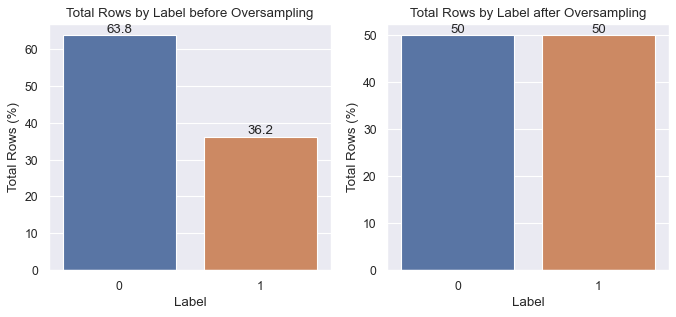

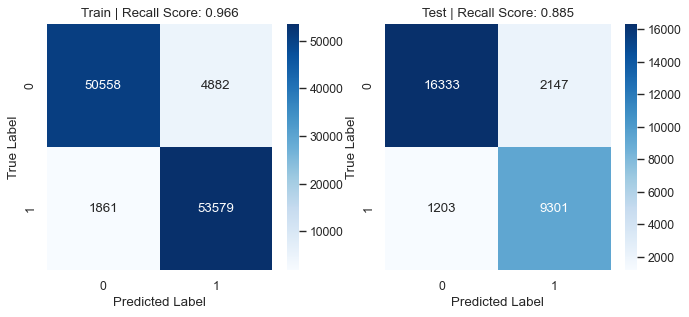

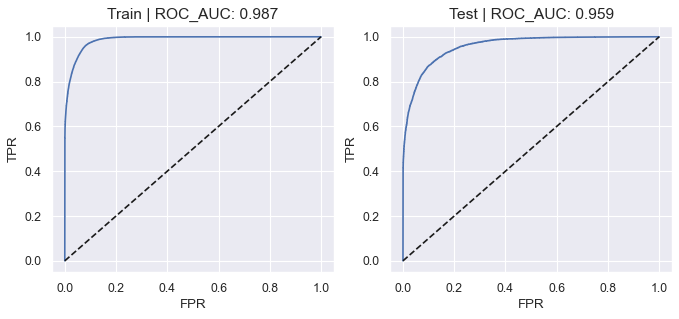

In [13]:
# Label for our dataset
label = ['is_canceled']

# Categorical columns that are going to be encoded
cat_cols = ['hotel', 'market_segment', 'is_repeated_guest', 'res_assign',
            'assigned_room_type', 'customer_type', 'deposit_type', 'arrival_date_month']

# Numerical columns that are going to be scaled
num_cols = [x for x in df.columns if not x in label + cat_cols + removed_cols]

X_train, X_test, y_train, y_test = split(df[num_cols + cat_cols + label], label=label)
model = RandomForestClassifier(random_state=42)
pipeline = preprocess(model, num_cols, cat_cols, [])
final_pipeline = model_fit(pipeline, X_train, X_test, y_train, y_test)

### <a id=35> 3.5 Our Model Explanation </a>

Our model, using the Random Forest Classifier, is executed above and the results from the model are shown. This section will discuss the specifics of our model and the final outcome. Pariticularly, this section will detail the metrics/scores produced, hyparameter tuning, graphical representations of the confusion matrix and ROC-AUC curve, and show the top 10 most impactful features. This section is organized as follows:

- [**3.5.1. Model Hyperparameters**](#a-id351-351-model-hyperparameters-a)
- [**3.5.2. Model Metric/Scores**](#a-id352-352-model-metricsscores-a)
- [**3.5.3. Model Graphical Representations**](#a-id353-353-model-graphical-representations-a)
- [**3.5.4. Model Feature Importance**](#a-id354-354-model-feature-importance-a)
- [**3.5.5. Positive and Negative Feature Correlation**](#355)

#### <a id=351> 3.5.1 Model Hyperparameters </a>

The following discusses the three hyperparameters that we have tuned for the Random Forest Classifier using the RandomizedSearchCV. Below we examine each hyperparameter:

1. *n_estimators*: The first hyperparameter we tune is *n_estimators*. Recall that in section 3.2 it is mentioned that *n_estimators* is the number of decision trees in our forest created by Random Forest Regressor. The RandomizedSearchCV takes values 100 to 300 in increments fo 20, meaning that 10 different values can be randomly selected to determine the optimal number of trees. Our model determines that the optimal number of decision trees to create is 100 for our dataset. As mentioned before, this means that our dataset is bootstrapped into 100 datasets, where each dataset will be individually fitted, creating 100 decision trees.
2. *max_depth*: The final hyperparameter that is tuned in *max_depth*. This is also mentioned in section 3.2, but essentially the *max_depth* is how deep our decision trees in our forest can go. This means how many levels of nodes we can have in our forest at most. Particularly, RandomizedSearchCV randomly takes values from 1 to 20 to determine our optimal model. Given the optimal forest depth of 19, no more than 19 levels of nodes produce the optimal preditictive value.

#### <a id=352> 3.5.2 Model Metrics/Scores </a>
In section [3.1](#31) we tried and tested Logistic Regression, Linear Support Vector Classification, and Decision Tree Classifier however both did not fit as well as Random Forest Classifier. Our scores for our models are as follows with:

| Metric  | Train Score  | Test Score | Ideal range  |
|---|---|---|---|
|  Recall | 0.966  |  0.885 | > 0.5  |
|  ROC-AUC | 0.987  | 0.959 |  > 0.5 |

The difference in the test and train scores could be explained by the model being slightly overfitting. However, we have controlled the *max_depth* in the Random Forest Classifier model and used **5-fold Cross Validation** to reduce this. Our suggestion to further improve our model is to integrate more features, such as the room price, remaining number of available rooms, and customer ID to know the historical record of each particular customer.

#### <a id=353> 3.5.3 Model Graphical Representations </a>

The following discusses the three graphs that are produced above. This excludes the feautre importance which is explained below:

1. **Oversampling**: This plot shows the oversampling effect on the data. We use the oversampling method and create plots to ensure that our dataset is more evenly distributed among each case. As seen in the left plot, the percentage of not canceled, 0, to is canceled, 1, is 63.8% to 36.3% respectively. After oversampling, we now have 50% of each case within our dataset.
2. **Confusion Matrix**: These plots depict the confusion matrix on the training and testing data. To add further clarity, we define 0 as not canceled and 1 as canceled. Therefore we have that a true positive is a booking that was not canceled and the prediction of our model is that it was not canceled as well. The following definitions of true negative, false positive, and false negative can all be defined in a similar manner. Notice that in the training set, the amount of true positives, 50558, and false negatives, 53579, largely outweighs the true negatives and false positives which cumulatively are 6743. This means that the prediction in our training data is approximately 94% correct. Notice as well that the Recall score is 0.966 which is good for our data. In the testing data, the model predicts 88% of the cases correctly. Notice that the Recall score is also lower. Therefore the prediction is not quite as accurate as the training data, however, the model still fits well to the testing data, with slight overfitting.
3. **ROC AUC**: These plots depict the ROC AUC (Receiver Operating Characteristic - Area Under the Curve) on the training and testing data. The ROC is a measure of the true positive rate vs. the false positive rate. Ideally, we would want the ROC AUC metric to be 1. As well, the curve itself should almost a right angle triangle with the diagonal and the left hand side and top of the plot if the model predicted the outcome of positive and negative classes perfectly. It is noticable that the training data appears to have this shape slightly more than our testing data. This also makes sense when looking at the ROC AUC metric for the training and testing data which is 0.987 and 0.959 respectively. This means that the training data was slightly better at predicting positive and negative classes than the training data, however, the numbers are quite close and both are very close to 1, indicating that the model was able to predict negative and positive classes well (almost perfectly in the training dataset). 

#### <a id=354> 3.5.4 Model Feature Importance </a>

**[TBU]** The graph of features importances shows a significant correlation between *total_votes* and imdb_rating of approximately 0.59. This is not suprising given that people are more likely to watch a higher rated episode and therefore vote. Suprisingly, *n_lines* was second most important, the are several possible explanations for this such as the show is more enteraining with lots of dialogue and therefore more jokes. Or that physical interactions with less diaglogue is more entertaining. In conclusion, these are just theories and we lack the data to explain this. However, the next section we will explore the postive and negative importance of each variable to understand the actual impact of the parameters.

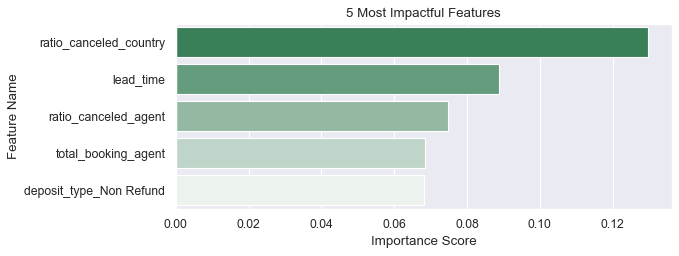

In [14]:
df_feature = show_feature_importances(final_pipeline, num_cols, cat_cols, topk=5)

#### <a id=355> 3.5.5  Positive and Negative Feature Correlation </a>

Based on the below graphs, it can be concluded that *ratio_canceled_country, ratio_canceled_agent, lead_time, total_booking_country,* and *total_booking_agent* are positively correlated with canceled probability, or in other words:

> - The higher the canceled booking ratio a country or an agent has, the higher the probability that the booking will be canceled.
> - The earlier the booking is made, the higher the chances that it is going to be canceled.
> - The greater the number of bookings that have been made from a country, the more likely the booking to be canceled. Intuitively, this might be due to the fact that considering the same canceled booking ratio, the model becomes more confident when it has learned more data.
> - It is depicted that Non Refund booking has higher chances of being canceled. Although it does seem like counter intuitive, the reason behind this result is the data itself.

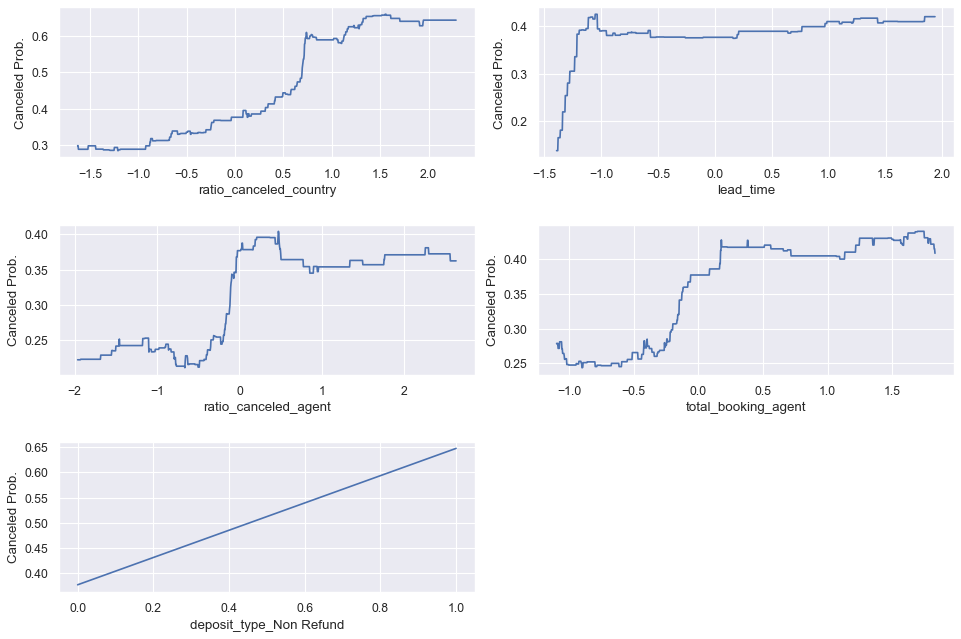

In [18]:
# Find positive or negative correlations from the features
data_training = Pipeline(final_pipeline.steps[:-1]).fit_transform(X_train)
cat_ohe_cols = list(final_pipeline['transform'].transformers_[1][1].get_feature_names_out())
df_training = pd.DataFrame(data_training, columns = num_cols + cat_ohe_cols)
fig, ax = plt.subplots(3, 2, figsize=(12, 8))
fig.tight_layout(w_pad=2, h_pad=3)
x, y = 0, 0

for col in df_feature['name']:
    df_new = pd.DataFrame(columns=df_training.columns)
    if col in num_cols:
        df_new.loc[:, col] = np.linspace(df_training[col].min(), df_training[col].max(), num=1000)
    else:
        df_new.loc[:, col] = [0, 1]
    for other_col in [x for x in df_training.columns if x != col]:
        if other_col in num_cols:
            # For numerical columns, take the mean
            df_new.loc[:, other_col] = df_training[other_col].mean()
        else:
            # For categorical columns, take the mode
            df_new.loc[:, other_col] = df_training[other_col].mode()[0]
            
    df_new['canceled_prob'] = final_pipeline['model'].predict_proba(df_new)[:, 1]
    sns.lineplot(df_new, x=col, y='canceled_prob', ax=ax[x, y])
    ax[x,y].set_ylabel('Canceled Prob.')

    if y == 1:
        x += 1
        y = 0
    else:
        y += 1
        
ax[2,1].set_axis_off()

It can be seen that 99% of the Non Refund booking is canceled (label 1). This explains why Non Refund booking has higher chances of being canceled.

Text(0, 0.5, 'Total Rows (%)')

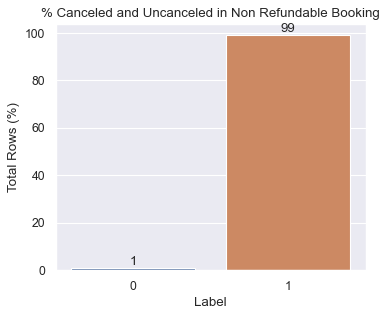

In [16]:
# Percentage of is_canceled in Non Refundable booking
plt.figure(figsize=(5,4))
ax = sns.barplot(pd.DataFrame(np.round(df[df['deposit_type'] == 'Non Refund']['is_canceled'].value_counts(normalize=True), 2)*100).reset_index(),
                         x='index', y='is_canceled')
plt.bar_label(ax.containers[0])
plt.title('% Canceled and Uncanceled in Non Refundable Booking')
plt.xlabel('Label')
plt.ylabel('Total Rows (%)')

## <a id=4> 4. Discussion and Conclusions </a>


### 4.1 Recapitulation 

Overall, in the data cleaning section, we processed the raw data by eliminating rows containing unreasonable or duplicate values and columns with predominantly invalid cells. Subsequently, we imputed the remaining null values and calibrated the data by converting and unifying it into specific types. Moving on to feature extraction, we identified potentially impactful features through statistical computations, such as *ratio_canceled_country* and *ratio_canceled_agent*. After conducting a correlation test, we further filtered out features with negligible correlations to our target and retained only one feature from each group that demonstrated conspicuous correlations with each other. Another crucial preliminary step before inputting data into our model involves feature scaling. In this process, we applied an oversampler to our data to ensure the number of positive instances is commensurate with that of negative instances. Additionally, we standardised the numerical data and encoded the categorical ones.

Following the aforementioned groundwork, we fitted the preprocessed data to the `RandomForestClassifier` using the optimal set of hyperparameters provided by `RandomizedSearchCV`, a method for hyperparameter tuning. **[TBU: a brief intro of the model]**

### 4.2 Discussion

As demonstrated by the results of our finalised model, an accurate prediction is drawn, with Recall scores of 0.950 and 0.762, and ROC-AUC scores of 0.984 and 0.916, for the train and test datasets respectively. Despite the promising accuracy, the relatively reduced scores for the test data reveal the possibility of overfitting. Nonetheless, to provide valid and applicable suggestions for business, it may not be sufficient to rely solely on the aforementioned scores as indicators. This has prompted us to interpret the metrics in terms of potential gains and losses that the hotel might face due to erroneous predictions.

Faulty outcomes can be categorised into two types: False Positives (FP) and False Negatives (FN). In the context of the hotel business, an FP occurs when customers who intend to honour their bookings are mistakenly predicted not to show up. This may lead the hotel to resell the booked room to another customer. If, on the check-in day, all rooms of the type booked by the original guest become occupied, the hotel will have to upgrade the room without charging extra fees. This comes at the cost of losing the opportunity to resell the upgraded room at its full price. The loss, in this case, is the difference between the price of the booked room and the upgraded one, which we assume is no more than the original room price (i.e., the upgraded room is up to twice the price of the original). In more extreme cases, if all rooms of any type are full, the hotel must compensate the customer in accordance with its terms and policies, which may vary across businesses. A widely used method is to cover the cost of the guest's stay in a nearby establishment, which can be estimated based on the price of the overbooked room. In summary, the loss resulting from an FP is no more than the price of the booked room. An FN, on the other hand, engenders the loss of the price of the booked room, as it sacrifices the opportunity to resell it when that particular room type is fully booked.

To sum up, losses of both types occur if and only if a specific circumstance arises: the intended room type is fully booked and a misclassification happens simultaneously. Whenever this situation occurs, namely, there is a loss, an FP is more preferable since the loss associated with an FP, which is less than or equal to the room price, is no greater than that of an FN, which amounts to the room price. Consequently, it becomes legitimate to aim for a higher recall in order to predict as many positives as possible, thereby minimising potential financial losses.

### 4.3 Suggestion

By ranking the features based on their significance, we have identified the five most impactful factors for the business to monitor closely: *ratio_canceled_country*, *ratio_canceled_agent*, *lead_time*, *total_booking_country*, *total_booking_agent*.

A explication for each is listed as follows:

1. *ratio_canceled_country*: This factor represents the cancellation rate of bookings from a specific country. A higher rate implies a greater probability of cancellation from this country.
2. *ratio_canceled_agent*: This refers to the cancellation rate associated with bookings made through a specific travel agent. This follows the same pattern as the rate above: a higher rate suggests more likely cancellations.
3. *lead_time*: This is the amount of time between the booking date and the arrival date. A longer lead time can be associated with a higher likelihood of cancellations, as plans are more likely to change when booked further in advance.
4. *total_booking_country*: This represents the total number of bookings made by guests from a particular country. A larger number hints that this country is a stable and predominant source of guests, and therefore, less likely to experience cancellations.
5. *total_booking_agent*: This factor indicates the total number of bookings made through a specific travel agent. A larger factor means this agent has more popularity and reliability, and thus a lower likelihood of cancellations.

These metrics not only offer a practical way to assess the probability of cancellation associated with each booking, but also provide businesses with insights to make informed decisions:
- Collaborate with partners of high credibility (agents of low *ratio_canceled_agent*) and relative dominance in the industry (agents of high *total_booking_agent*).
- Adjust marketing and promotional strategies, focusing on and customising for the major markets (countries with *high total_booking_country*) through paramount channels (agents with *high total_booking_agent*).
- Identify the optimal moment to release discounts, which aims at reducing *lead_time* and, in turn, lowering the chances of cancellations. However, this is a trade-off between keeping cancellations at bay and increasing the occupancy rate, since delaying the release of discounts reduces *lead_time* but may not achieve an ideal occupancy rate.

# **Recommendations**

**[TBU]**
Internal Variables:

- The optimal **spoken lines** for the new episode are between 378 and 460
- The **director** for the new episode can either be Ken Kwapis, Paul Feig, or Jeffrey Blitz; or combination of them. 
- For the **number of main characters**, we suggest that the new episode casts at least 15 people.

External Variables:
- The higher the popularity of the epsiode the better. Therefore we recommend as much advertising as possible to gain as traction for the episode as possible.

**Disclaimer:** This model is designed to give recomendations for the highest IMDB rating as possible for the reunion episode. Noteworthily there is a disparity between an episode's popularity and it's IMDB rating, and there is not enough evidence to buttress a solid correlation between them. However, a high-rated episode is likely to favour the popularity in general, so for those particularly interested in the popularity, you may use the IMDB rating as an index for popularity, and thus the favourable factors we have firgured out may help. 

## 5. References

[1] Aurelien Geron. 2019. Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow: Concepts, Tools, and Techniques to Build Intelligent Systems (2nd. ed.). O'Reilly Media, Inc.

[2] Antonio, N., de Almeida, A., & Nunes, L. (2019). Hotel booking demand datasets. Data in Brief, 22, 41-49. https://doi.org/10.1016/j.dib.2018.11.126